In [1]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc
import scipy as sp
from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample
from optic.comm.metrics import signal_power,fastBERcalc
from optic.dsp.equalization import *
from optic.plot import eyediagram
plt.rcParams["figure.figsize"] = (12,6)

from funcoesLab import *

c:\Users\lucas\anaconda3\envs\Opticompy\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


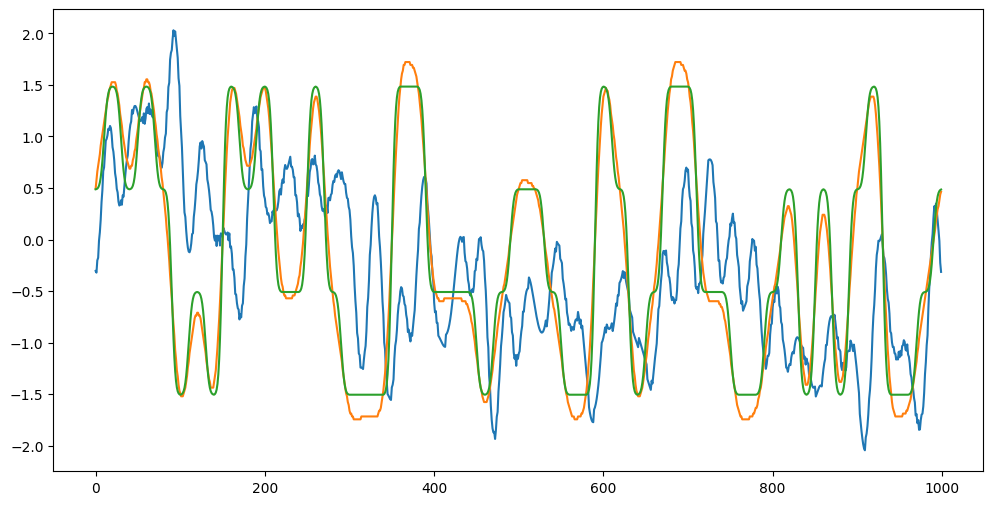

In [72]:
variaveis = np.load('250Mbould-4SpS.npz')
variaveis.files

simbolos = pnorm(variaveis['simbolos']-np.mean(variaveis['simbolos']))
t = variaveis['t']
y = pnorm(variaveis['y']-np.mean(variaveis['y']))
ysicronizado = pnorm(variaveis['ysicronizado']-np.mean(variaveis['ysicronizado']))


nsimbolos=1e4

from optic.utils import parameters
teste = parameters()
teste.numIter =20000
teste.SpS =int(len(y)/(nsimbolos))
teste.storeCoeff = False
teste.constType = 'pam'
teste.nTaps = 200
teste.mu = [0.00001]
#teste.alg ='lms'
teste.returnResults = True
teste.L = [teste.nTaps]
yEq,h,erro = mimoAdaptEqualizer(ysicronizado,teste,dx=simbolos)



sinalequalizado = pnorm(sp.signal.fftconvolve(ysicronizado,h[0]))
# sinalequalizado = sp.signal.lfilter(h[0],1,ysicronizado)
# sinalequalizado = (sinalequalizado - np.mean(sinalequalizado))[int(len(sinalequalizado) - len(ysicronizado)):]

plt.plot(sinalequalizado[100000:101000])
plt.plot(ysicronizado[100000:101000])
plt.plot(simbolos[100000:101000])
#plt.plot((yEq[100000:101000]))

# lms 

[ 9.99999937e-01  4.99999987e-01  2.99999974e-01 -3.48398374e-08
 -1.00000009e-01]


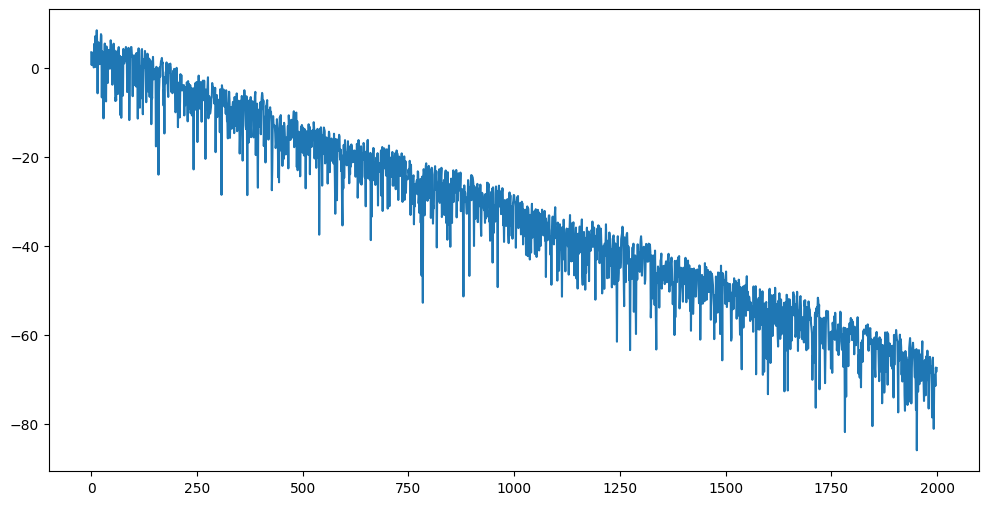

In [85]:
def LMS(x,d,L,μ,Niterações):
    x = np.append(np.zeros(L-1),x)
    W = np.zeros(L)
    erro = np.zeros(Niterações)

    for i in range(Niterações):
        xcortado = np.flip(x[i:L+i])
        erro[i] = d[i] - np.sum(W*xcortado)
        W = W + μ*erro[i]*xcortado
    return W,erro

x = np.random.uniform(-5,5,10000)
hcorreto = [1,0.5,0.3,0,-0.1]
y = sp.signal.fftconvolve(x,hcorreto)

hestimado, erro = LMS(x,y,5,0.001,2000)
print(hestimado)
plt.plot(10*np.log10(np.abs(erro)))

C:\Users\lucas\AppData\Local\Temp\ipykernel_29520\899584561.py:50: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(np.abs(erro)))
C:\Users\lucas\AppData\Local\Temp\ipykernel_29520\899584561.py:53: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(np.abs(erro)))


(199800.0, 200000.0)

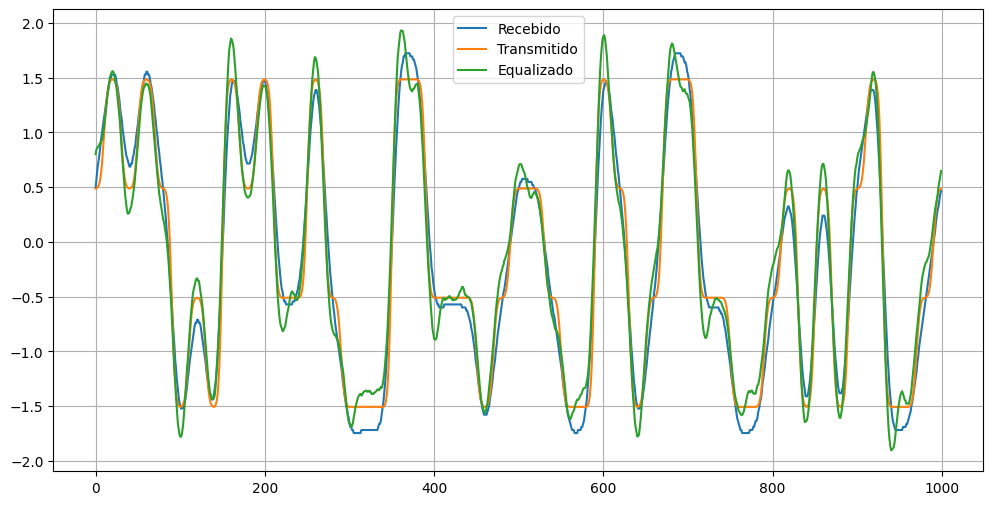

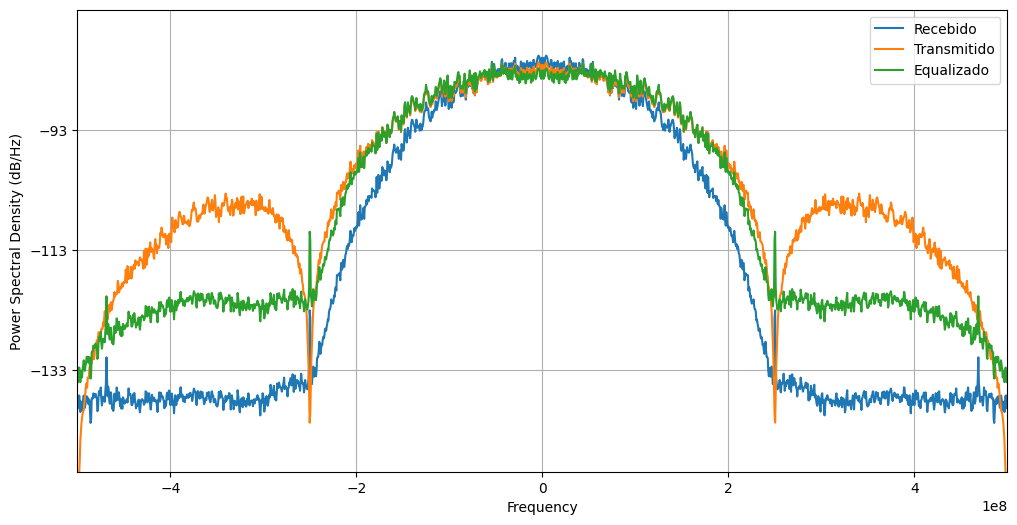

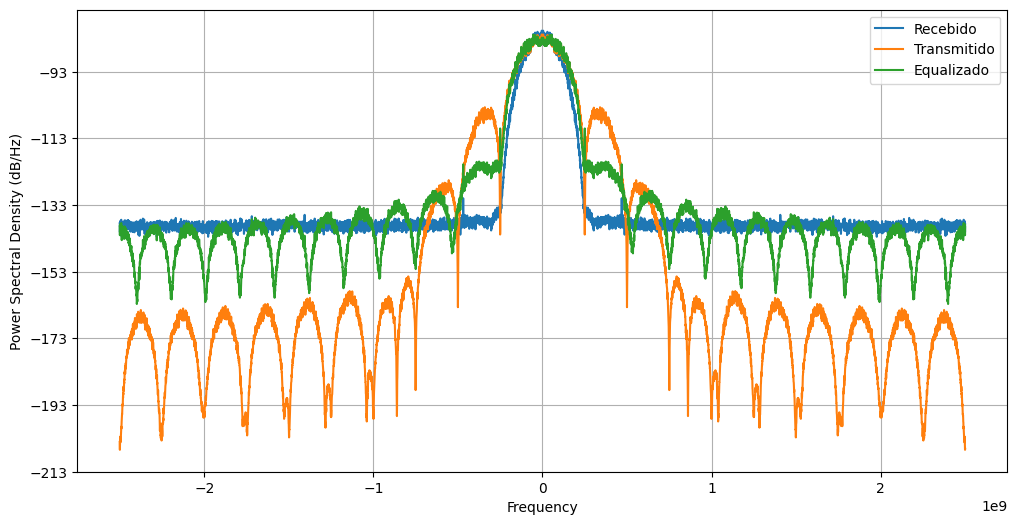

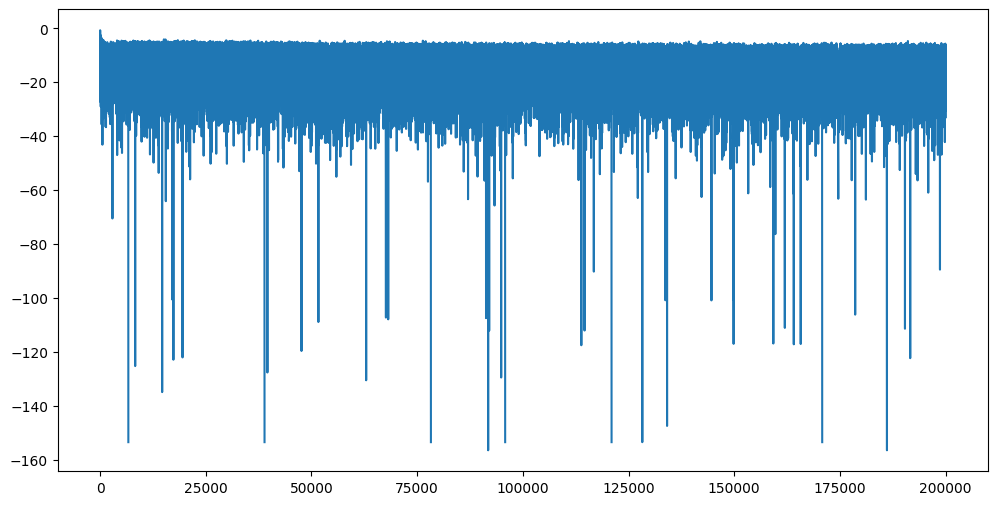

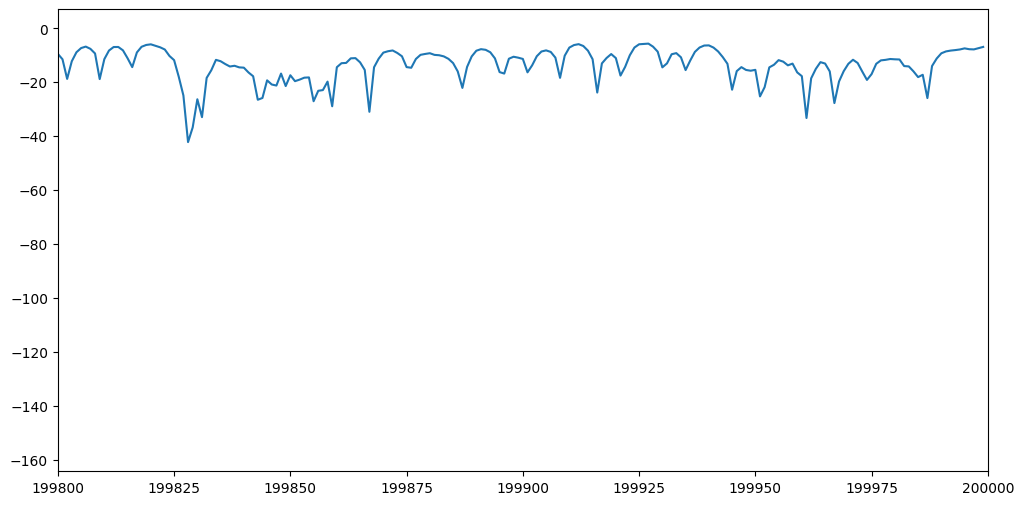

In [156]:
def LMS(x,d,L,μ,Niterações):
    x = np.append(np.zeros(L-1),x)
    W = np.zeros(L)
    erro = np.zeros(Niterações)

    for i in range(Niterações):
        xcortado = np.flip(x[i:L+i])
        erro[i] = d[i] - np.sum(W*xcortado)
        W = W + μ*erro[i]*xcortado
    return W,erro

variaveis = np.load('250Mbould-4SpS.npz')

simbolos = pnorm(variaveis['simbolos']-np.mean(variaveis['simbolos']))
t = variaveis['t']
y = pnorm(variaveis['y']-np.mean(variaveis['y']))
ysicronizado = pnorm(variaveis['ysicronizado']-np.mean(variaveis['ysicronizado']))


L = 25
μ = 0.01
Niterações = 200000

W,erro = LMS(ysicronizado,simbolos,L,μ,Niterações)
yeq = pnorm(sp.signal.fftconvolve(ysicronizado,W))

plt.plot(ysicronizado[100000:101000], label = 'Recebido')
plt.plot(simbolos[100000:101000], label = 'Transmitido')
plt.plot(yeq[100000:101000], label = 'Equalizado')
plt.legend()
plt.grid()

plt.figure(2)
plt.psd(pnorm(ysicronizado-np.mean(ysicronizado)),Fs=1/(t[1]-t[0]), NFFT = 8*1024, sides='twosided', label = 'Recebido')
plt.psd(pnorm(simbolos-np.mean(simbolos)),Fs=1/(t[1]-t[0]), NFFT = 8*1024, sides='twosided', label = 'Transmitido')
plt.psd(pnorm(yeq-np.mean(yeq)),Fs=1/(t[1]-t[0]), NFFT = 8*1024, sides='twosided', label = 'Equalizado')
plt.xlim(-2*250e6,2*250e6)
plt.ylim(-150,-73)
plt.legend()

plt.figure(3)
plt.psd(pnorm(ysicronizado-np.mean(ysicronizado)),Fs=1/(t[1]-t[0]), NFFT = 8*1024, sides='twosided', label = 'Recebido')
plt.psd(pnorm(simbolos-np.mean(simbolos)),Fs=1/(t[1]-t[0]), NFFT = 8*1024, sides='twosided', label = 'Transmitido')
plt.psd(pnorm(yeq-np.mean(yeq)),Fs=1/(t[1]-t[0]), NFFT = 8*1024, sides='twosided', label = 'Equalizado')
#plt.xlim(-5*250e6,5*250e6)
#plt.ylim(-150,-73)
plt.legend()

plt.figure(4)
plt.plot(10*np.log10(np.abs(erro)))

plt.figure(5)
plt.plot(10*np.log10(np.abs(erro)))
plt.xlim(len(erro)-200,len(erro))

C:\Users\lucas\AppData\Local\Temp\ipykernel_29520\2523297492.py:50: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(np.abs(erro)))
C:\Users\lucas\AppData\Local\Temp\ipykernel_29520\2523297492.py:53: RuntimeWarning: divide by zero encountered in log10
  plt.plot(10*np.log10(np.abs(erro)))


(199800.0, 200000.0)

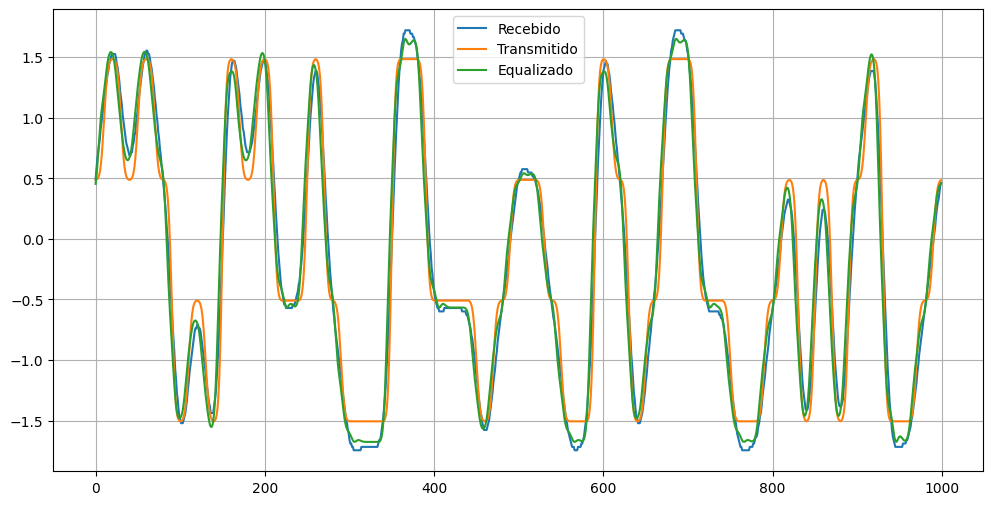

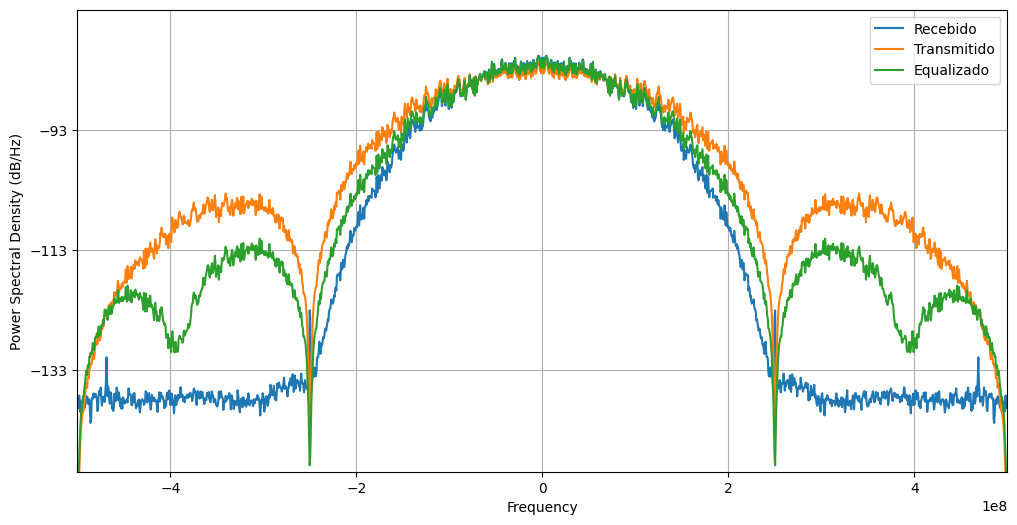

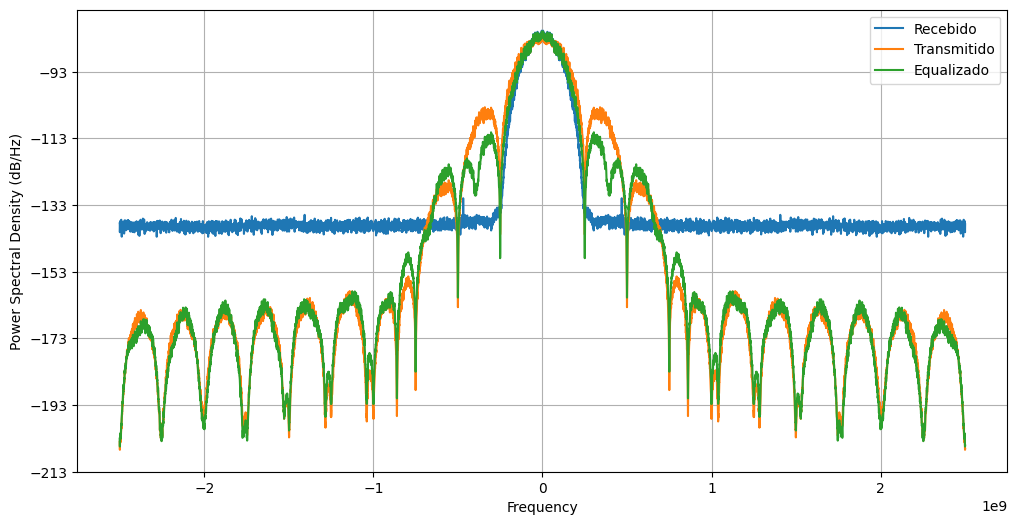

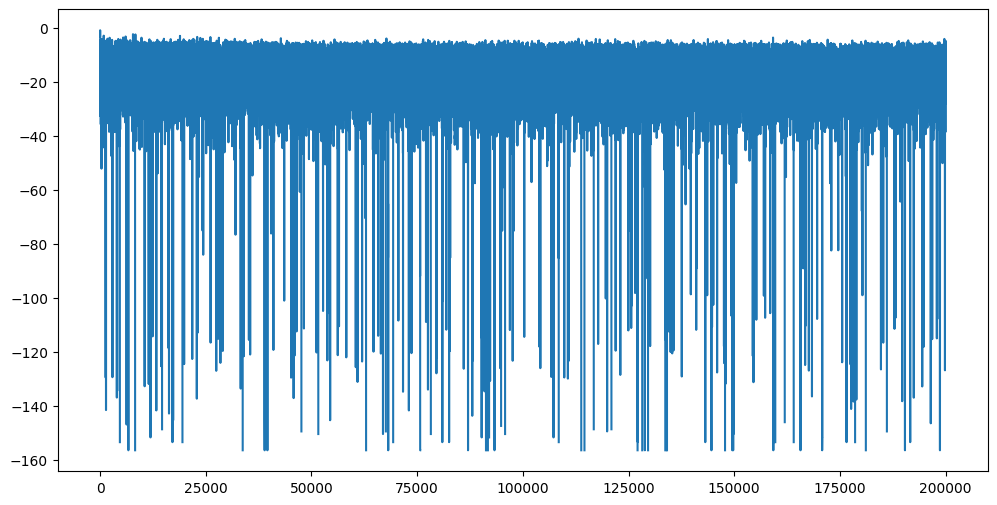

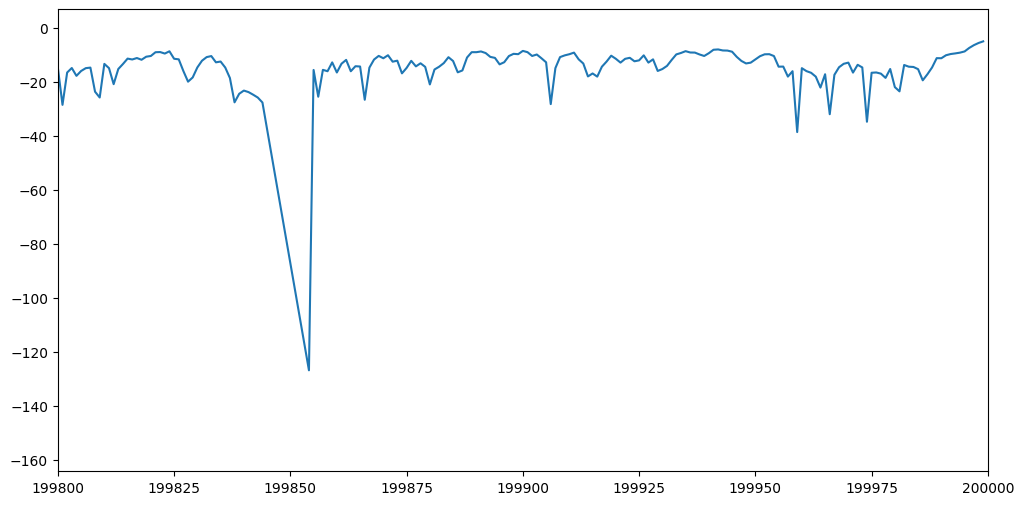

In [153]:
def LMS(x,d,L,μ,Niterações):
    x = np.append(np.zeros(L-1),x)
    W = np.zeros(L)
    erro = np.zeros(Niterações)

    for i in range(Niterações):
        xcortado = np.flip(x[i:L+i])
        erro[i] = d[i] - np.sum(W*xcortado)
        W = W + μ*erro[i]*xcortado
    return W,erro

variaveis = np.load('250Mbould-4SpS.npz')

simbolos = pnorm(variaveis['simbolos']-np.mean(variaveis['simbolos']))
t = variaveis['t']
y = pnorm(variaveis['y']-np.mean(variaveis['y']))
ysicronizado = pnorm(variaveis['ysicronizado']-np.mean(variaveis['ysicronizado']))


L = 25
μ = 0.02
Niterações = 200000

W,erro = LMS(simbolos,ysicronizado,L,μ,Niterações)
yeq = pnorm(sp.signal.fftconvolve(simbolos,W)[5:])

plt.plot(ysicronizado[100000:101000], label = 'Recebido')
plt.plot(simbolos[100000:101000], label = 'Transmitido')
plt.plot(yeq[100000:101000], label = 'Equalizado')
plt.legend()
plt.grid()

plt.figure(2)
plt.psd(pnorm(ysicronizado-np.mean(ysicronizado)),Fs=1/(t[1]-t[0]), NFFT = 8*1024, sides='twosided', label = 'Recebido')
plt.psd(pnorm(simbolos-np.mean(simbolos)),Fs=1/(t[1]-t[0]), NFFT = 8*1024, sides='twosided', label = 'Transmitido')
plt.psd(pnorm(yeq-np.mean(yeq)),Fs=1/(t[1]-t[0]), NFFT = 8*1024, sides='twosided', label = 'Equalizado')
plt.xlim(-2*250e6,2*250e6)
plt.ylim(-150,-73)
plt.legend()

plt.figure(3)
plt.psd(pnorm(ysicronizado-np.mean(ysicronizado)),Fs=1/(t[1]-t[0]), NFFT = 8*1024, sides='twosided', label = 'Recebido')
plt.psd(pnorm(simbolos-np.mean(simbolos)),Fs=1/(t[1]-t[0]), NFFT = 8*1024, sides='twosided', label = 'Transmitido')
plt.psd(pnorm(yeq-np.mean(yeq)),Fs=1/(t[1]-t[0]), NFFT = 8*1024, sides='twosided', label = 'Equalizado')
#plt.xlim(-5*250e6,5*250e6)
#plt.ylim(-150,-73)
plt.legend()

plt.figure(4)
plt.plot(10*np.log10(np.abs(erro)))

plt.figure(5)
plt.plot(10*np.log10(np.abs(erro)))
plt.xlim(len(erro)-200,len(erro))

(array([3.78975960e-08, 1.01180355e-07, 1.74483214e-07, 2.87416635e-07,
        4.27061912e-07, 5.77172799e-07, 7.19919672e-07, 8.37972577e-07,
        9.16773341e-07, 9.46796394e-07, 9.25555334e-07, 8.59089286e-07,
        7.62670756e-07, 6.60522402e-07, 5.84416275e-07, 5.71150342e-07,
        6.59041486e-07, 8.83723241e-07, 1.27366829e-06, 1.84594780e-06,
        2.60277294e-06, 3.52932651e-06, 4.59328155e-06, 5.74622820e-06,
        6.92700813e-06, 8.06671548e-06, 9.09489666e-06, 9.94630037e-06,
        1.05674230e-05, 1.09220806e-05, 1.09953238e-05, 1.07951913e-05,
        1.03520434e-05, 9.71551155e-06, 8.94938590e-06, 8.12502278e-06,
        7.31403471e-06, 6.58111378e-06, 5.97781726e-06, 5.53801624e-06,
        5.27549205e-06, 5.18388950e-06, 5.23893971e-06, 5.40258653e-06,
        5.62842787e-06, 5.86774428e-06, 6.07534744e-06, 6.21454439e-06,
        6.26066517e-06, 6.20281923e-06, 6.04379615e-06, 5.79827316e-06,
        5.48970257e-06, 5.14639842e-06, 4.79740770e-06, 4.468732

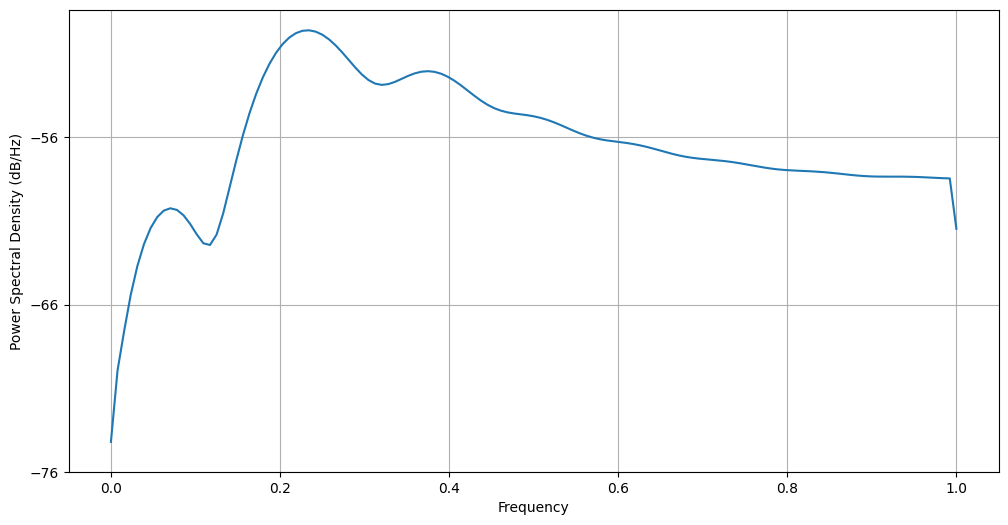

In [135]:
plt.psd(W)

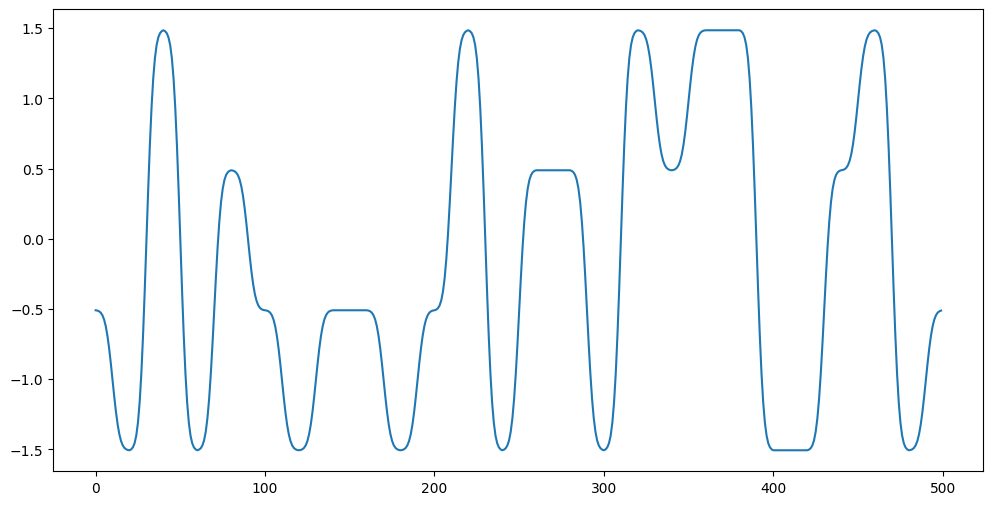

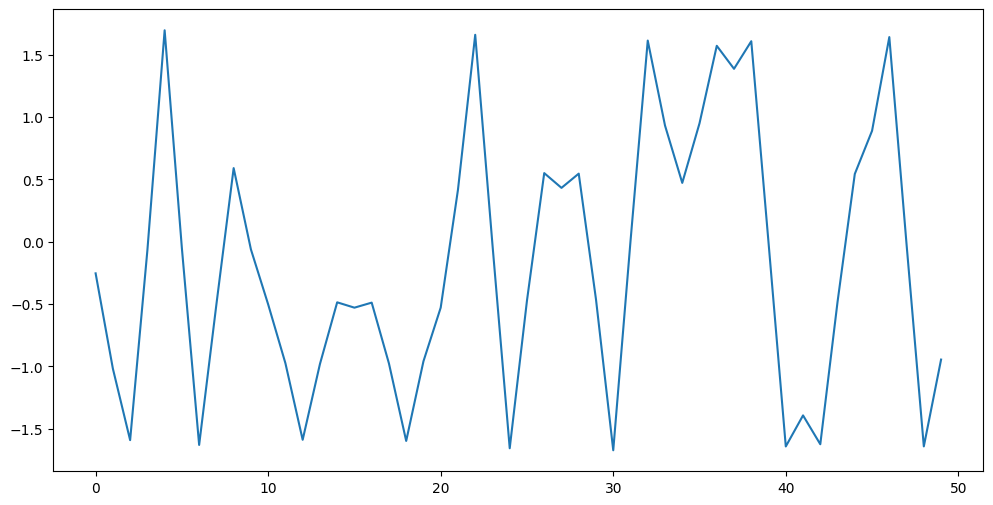

In [40]:
decimação = 10
resampled = sp.signal.resample(simbolos,len(simbolos)//decimação)
plt.figure(1)
plt.plot(simbolos[0:500])
plt.figure(2)
plt.plot(resampled[0:50])

# Resample

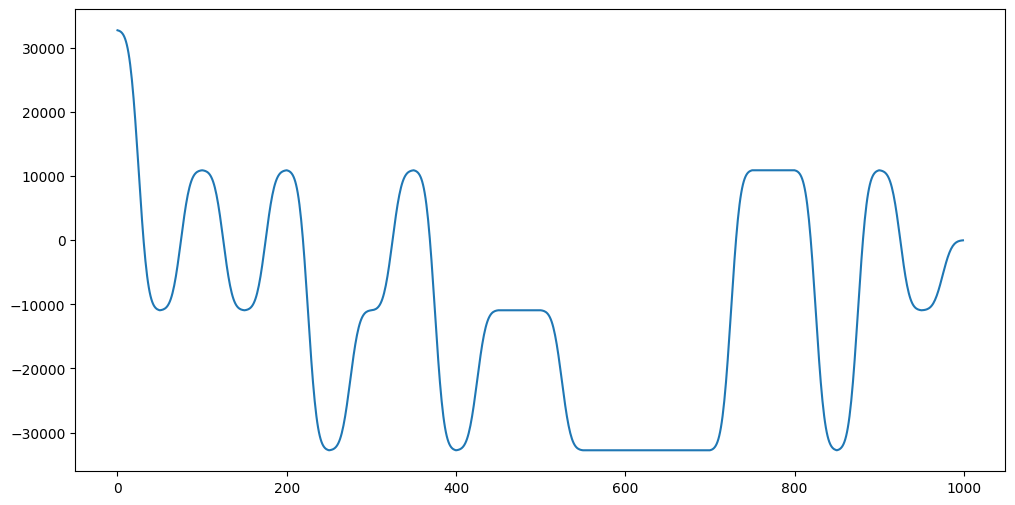

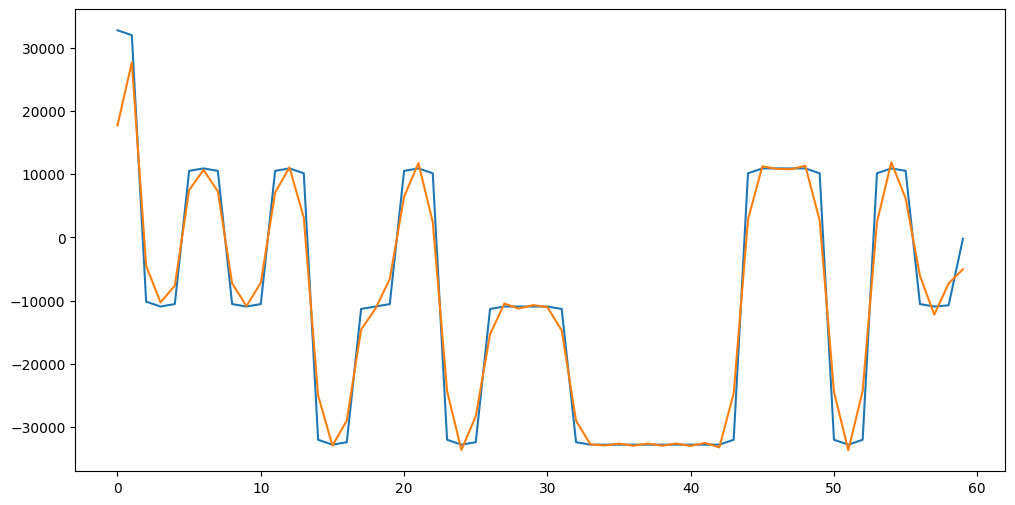

In [218]:

M = 4 # order of the modulation format
nsimbolos = 20
SPS = 50
formatoPulso = 'nrz' #'rect','nrz','rrc'
nTaps = 1024
alpha = 0.01

#bits,simbolos = Gerar_Simbolos(M,nsimbolos,SPS,formatoPulso,nTaps,alpha)
bits,simbolos20 = Gerar_Simbolos(M,nsimbolos,50,formatoPulso,nTaps,alpha,bits)
bits,simbolos5 = Gerar_Simbolos(M,nsimbolos,3,formatoPulso,nTaps,alpha,bits)
plt.plot(simbolos20)
plt.figure(2)
simbolos5nov0 = sp.signal.resample(simbolos20,len(simbolos5))
plt.plot(simbolos5)
plt.plot(simbolos5nov0)

In [250]:
x = np.array([1,2,3,4,5])
x[0::3]

array([1, 4])

(19800.0, 20000.0)

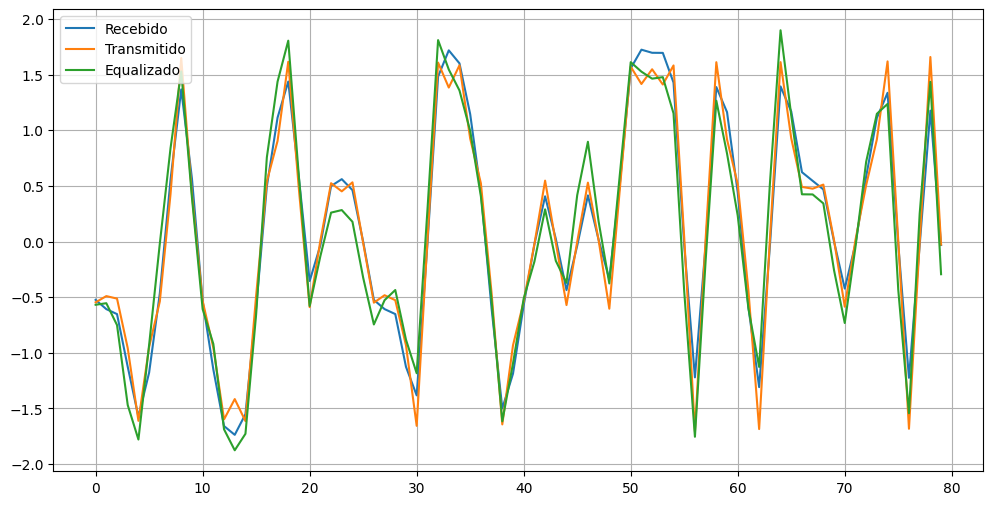

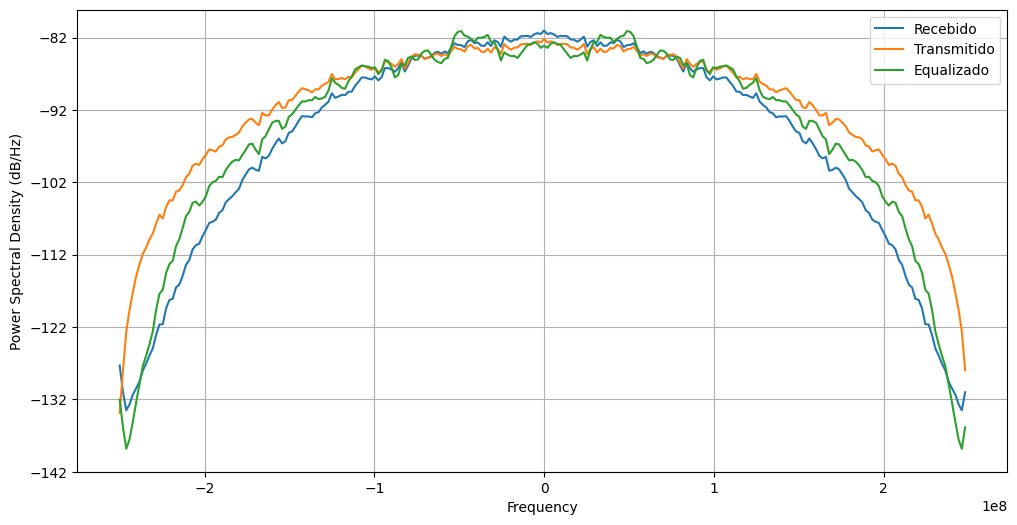

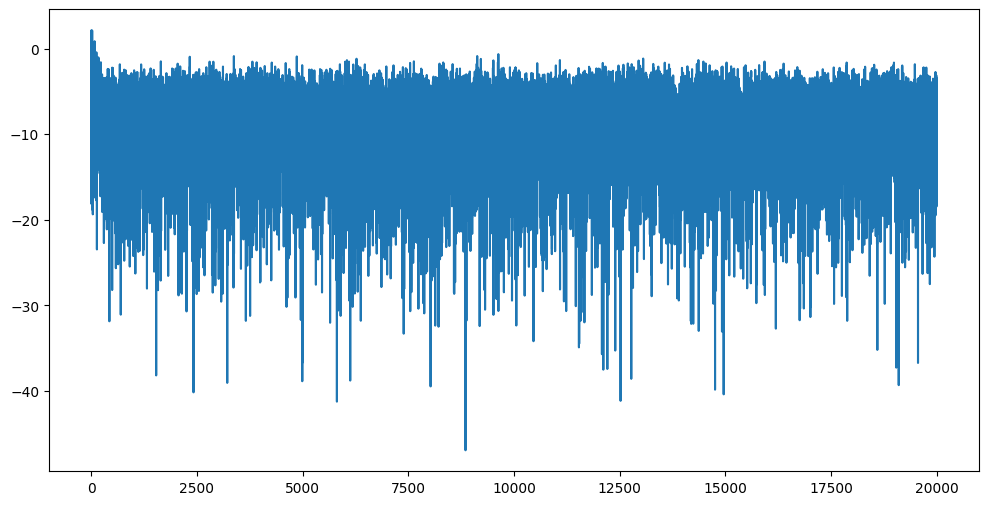

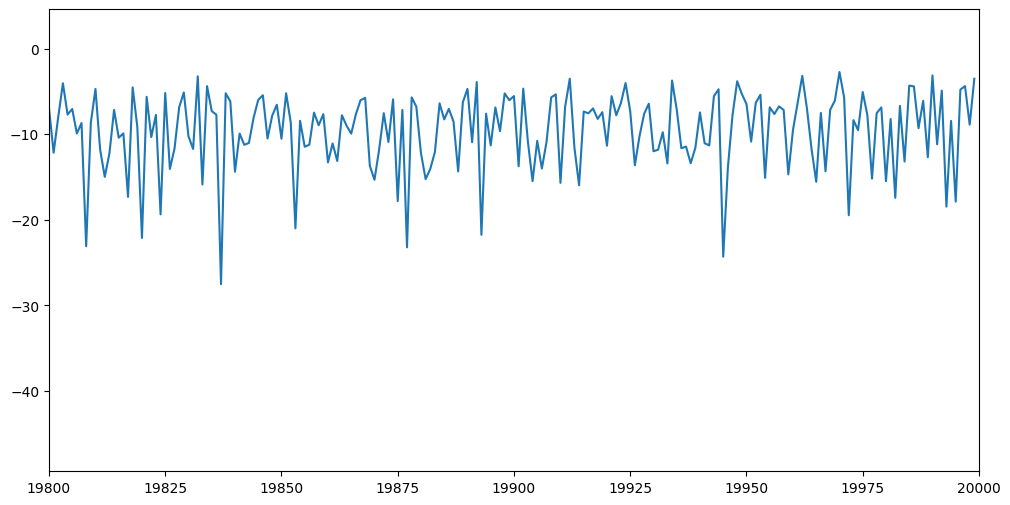

In [256]:
def LMS(x,d,L,μ,Niterações):
    x = np.append(np.zeros(L-1),x)
    W = np.zeros(L)
    erro = np.zeros(Niterações)

    for i in range(Niterações):
        xcortado = np.flip(x[i:L+i])
        erro[i] = d[i] - np.sum(W*xcortado)
        W = W + μ*erro[i]*xcortado
    return W,erro

variaveis = np.load('250Mbould-4SpS.npz')

simbolos = pnorm(variaveis['simbolos']-np.mean(variaveis['simbolos']))
t = variaveis['t']
y = pnorm(variaveis['y']-np.mean(variaveis['y']))
ysicronizado = pnorm(variaveis['ysicronizado']-np.mean(variaveis['ysicronizado']))


ysicronizado = sp.signal.resample(ysicronizado,len(ysicronizado)*5//50)
simbolos = sp.signal.resample(simbolos,len(simbolos)*5//50)

L = 50
μ = 0.02
Niterações = 200000*5//50

W,erro = LMS(ysicronizado,simbolos,L,μ,Niterações)
yeq = pnorm(sp.signal.fftconvolve(ysicronizado,W))

plt.plot(ysicronizado[1000:1080], label = 'Recebido')
plt.plot(simbolos[1000:1080], label = 'Transmitido')
plt.plot(yeq[1000:1080], label = 'Equalizado')
plt.legend()
plt.grid()

plt.figure(3)
plt.psd(pnorm(ysicronizado-np.mean(ysicronizado)),Fs=(1/(t[1]-t[0]))*5//50, sides='twosided', label = 'Recebido')
plt.psd(pnorm(simbolos-np.mean(simbolos)),Fs=(1/(t[1]-t[0]))*5//50, sides='twosided', label = 'Transmitido')
plt.psd(pnorm(yeq-np.mean(yeq)),Fs=(1/(t[1]-t[0]))*5//50, sides='twosided', label = 'Equalizado')
#plt.xlim(-5*250e6,5*250e6)
#plt.ylim(-150,-73)
plt.legend()

plt.figure(4)
plt.plot(10*np.log10(np.abs(erro)))

plt.figure(5)
plt.plot(10*np.log10(np.abs(erro)))
plt.xlim(len(erro)-200,len(erro))
